# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Импорт библиотек

In [1]:
# импортирую библиотеки
!pip install sweetviz -q
import pandas as pd
import sklearn
import sweetviz as sv
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

### Исследование данных 

In [2]:
autos = pd.read_csv('/datasets/autos.csv')
display(autos.shape)
display(autos.head(2))
autos.info()

(354369, 16)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

<div class="alert alert-info">
    
<font size="3"><b> 354369 строк, 16 столбцов. Есть пропуски.
    
    
    Признаки:

    DateCrawled — дата скачивания анкеты из базы    
    VehicleType — тип автомобильного кузова    
    RegistrationYear — год регистрации автомобиля    
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    NotRepaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя
    
    Целевой признак:

    Price — цена (евро)
</b></font>
    
</div>

In [3]:
# пропуски
autos.isna().sum() 

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

<AxesSubplot:>

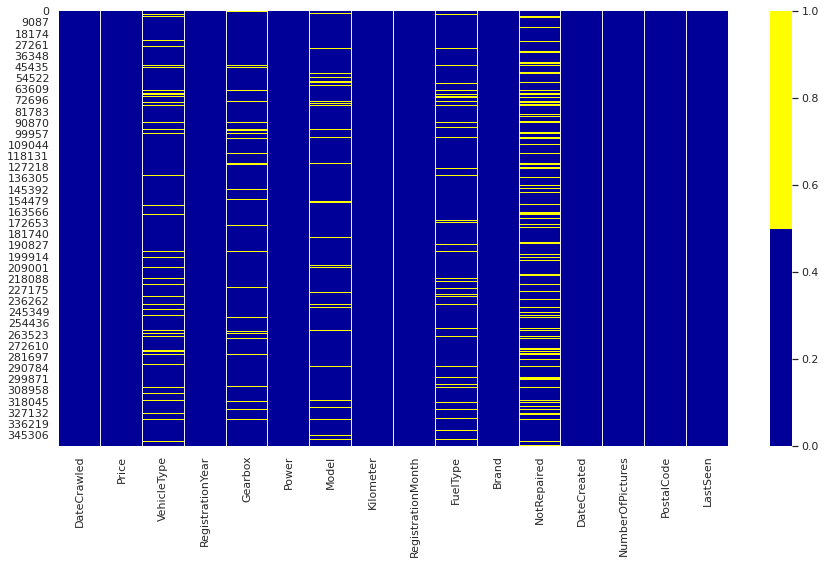

In [4]:
# пропуски визуально
cols1 = autos.columns # первые 43 колонки
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(autos[cols1].isnull(), cmap=sns.color_palette(colours))

<div class="alert alert-info">
    
<font size="3"><b> Пропуски в столбцах - VehicleType, Gearbox, Model, FuelType, NotRepaired.

</b></font>
    
</div>

### Дубликаты

In [5]:
autos.duplicated().sum()

4

In [6]:
autos = autos.drop_duplicates()
autos.duplicated().sum()

0

<div class="alert alert-info">
    
<font size="3"><b> Удалили дубликаты.

</b></font>
    
</div>

### Статистика 

#### Общая

In [7]:
# статистика
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [8]:
autos.describe(include='object')

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
count,354365,316875,334532,334660,321470,354365,283211,354365,354365
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268249,29232,216349,77012,247158,13718,17


<div class="alert alert-info">
    
<font size="3"><b> В общем чехарда, посмотрим подробнее.

</b></font>
    
</div>

#### Отчет Sweetviz

In [9]:
# анализируем данные
report_0 = sv.analyze(autos)

                                             |          | [  0%]   00:00 -> (? left)

Report common_analysis.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



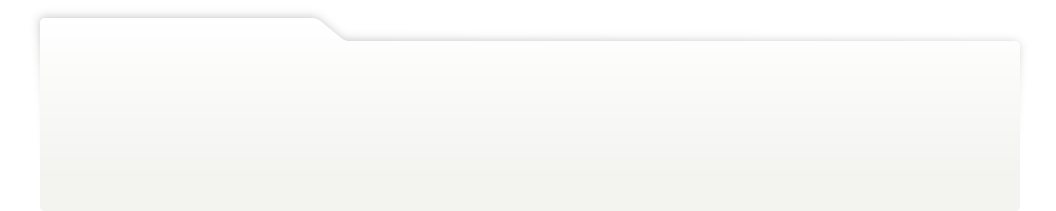
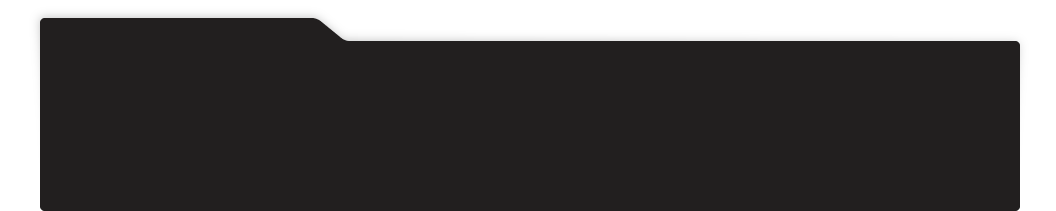
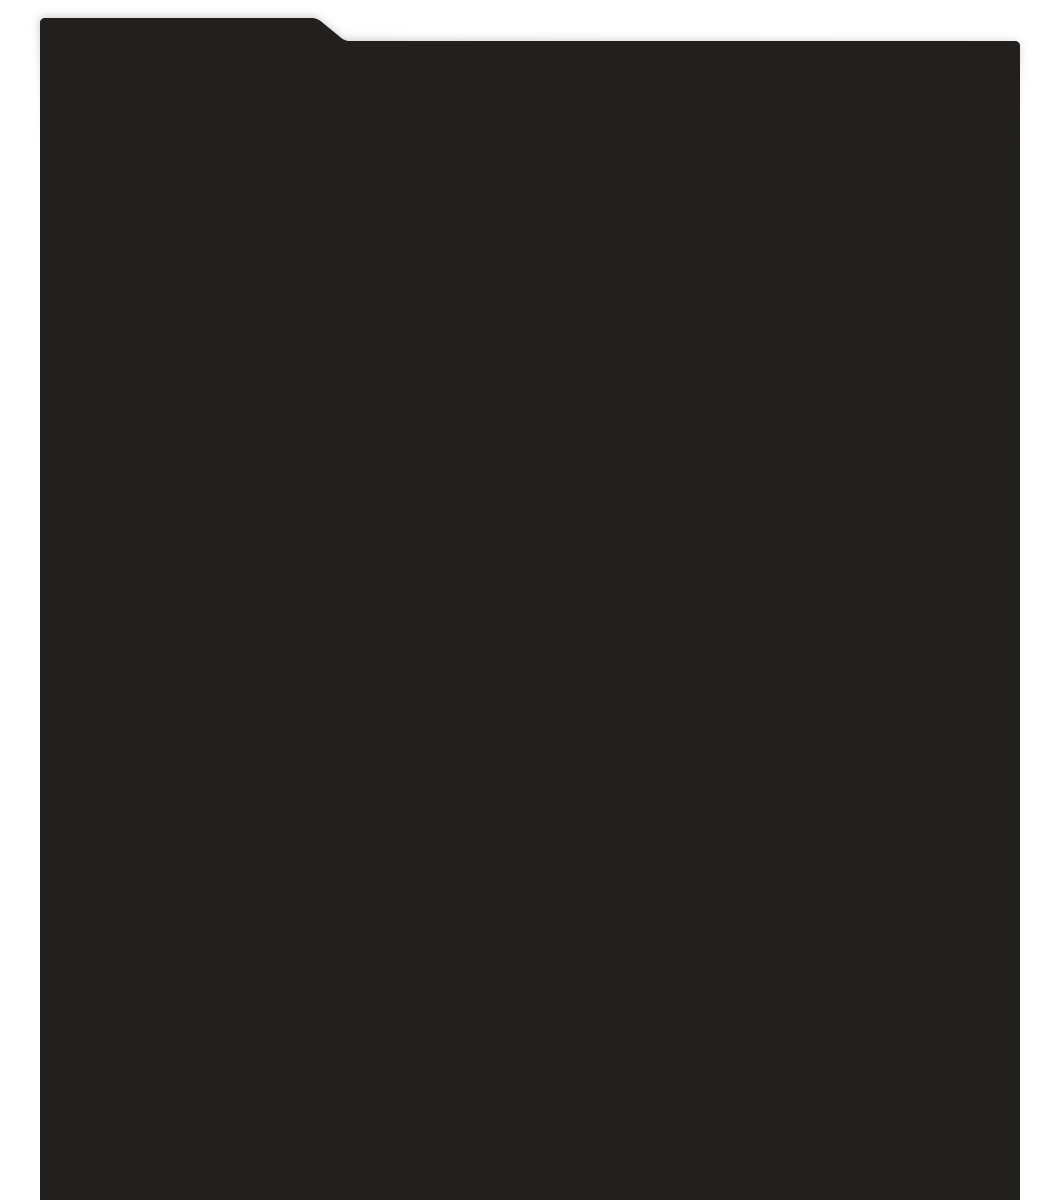
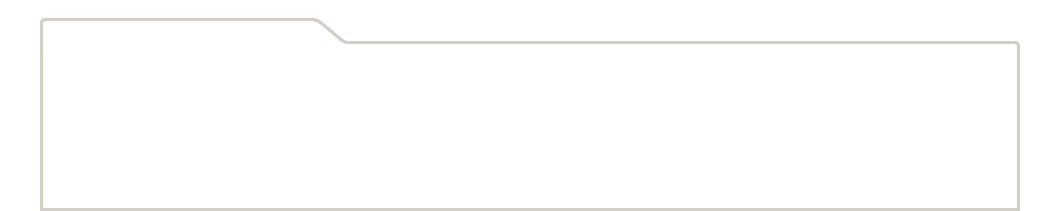
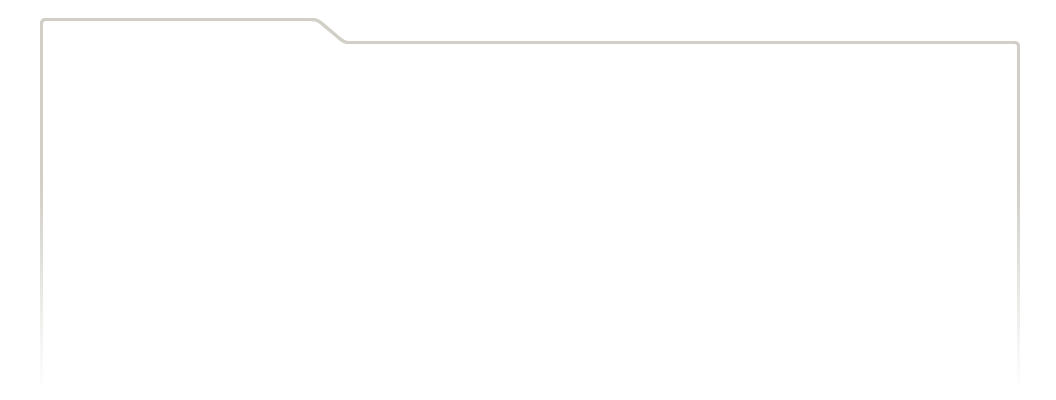
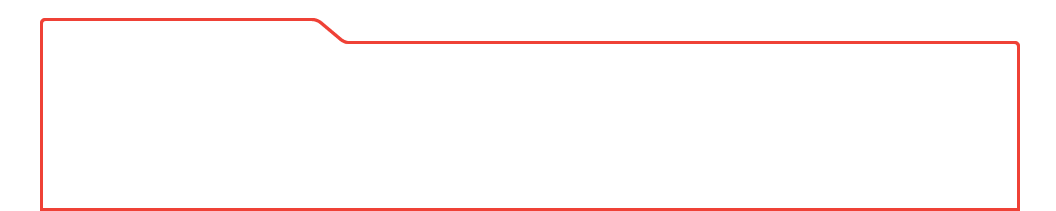
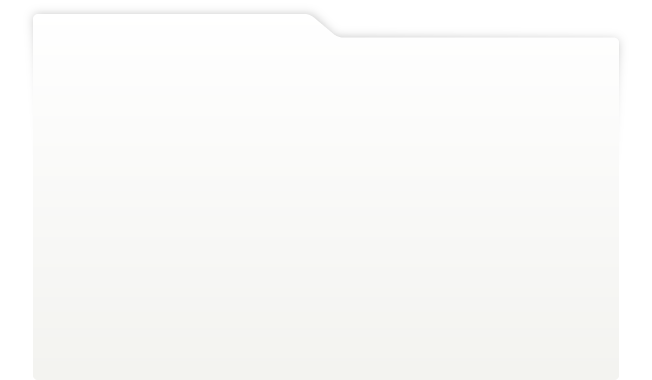
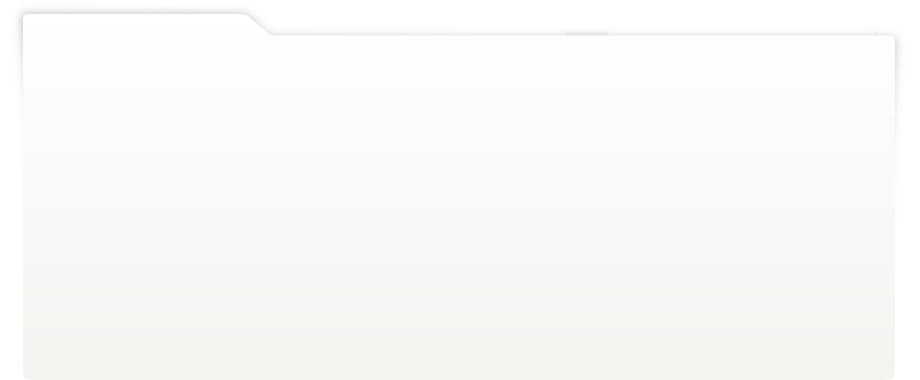
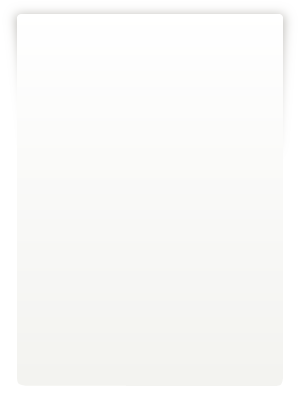
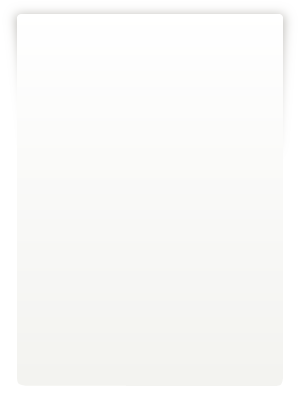
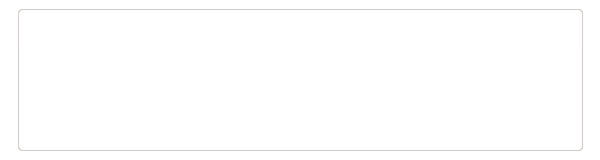
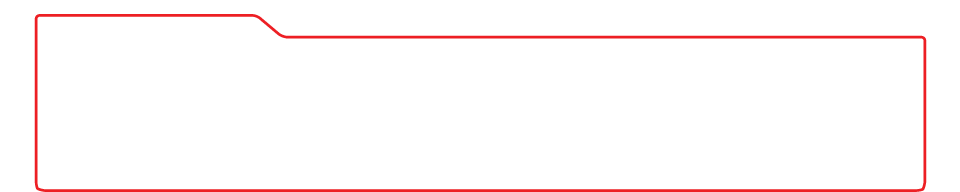
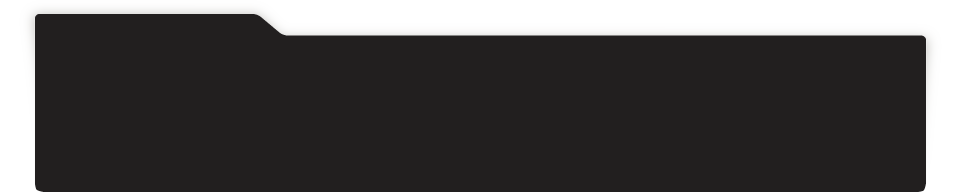
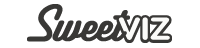
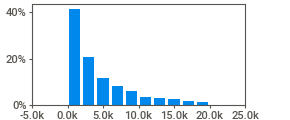
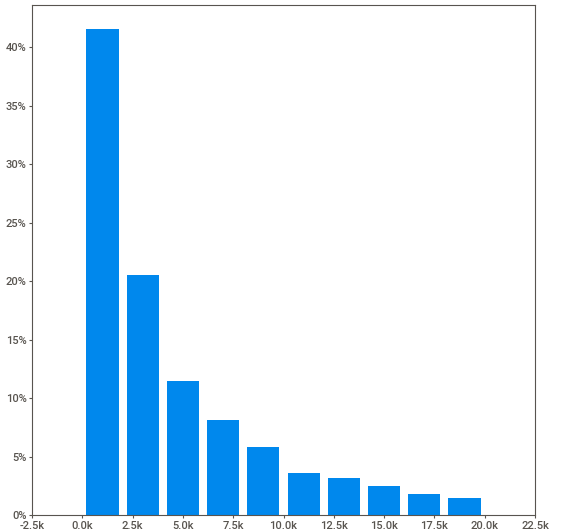
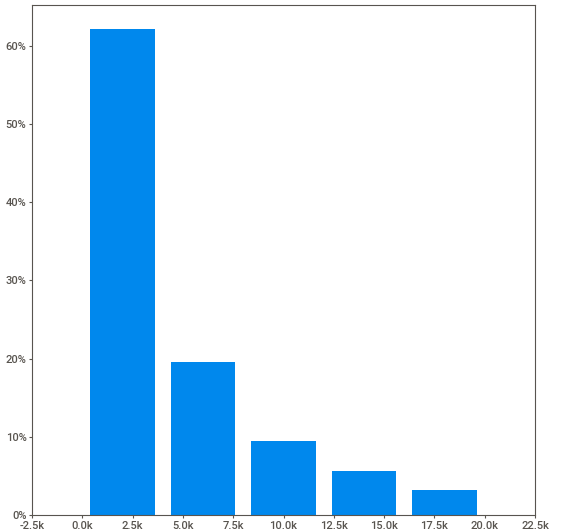
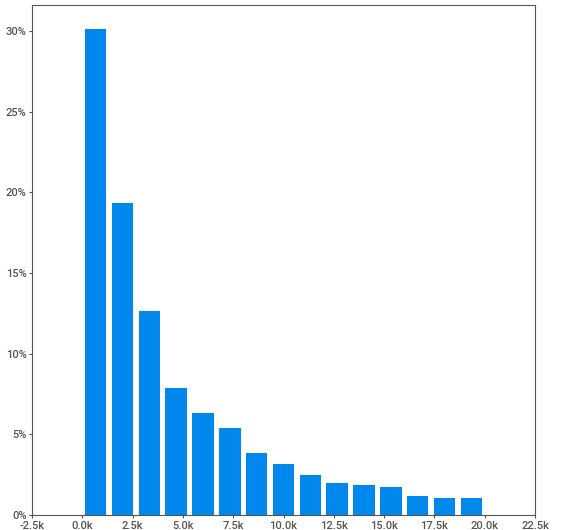
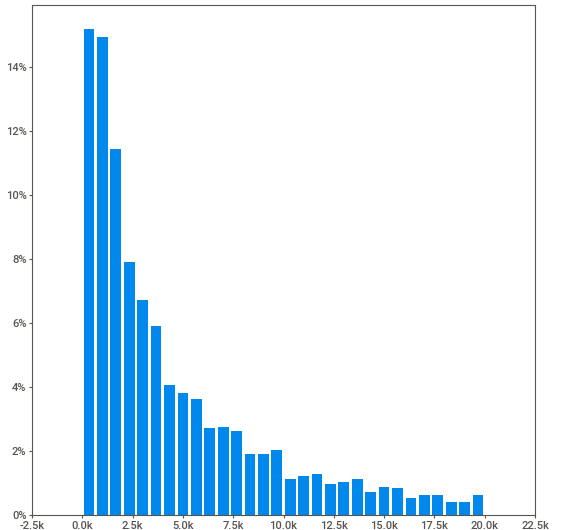
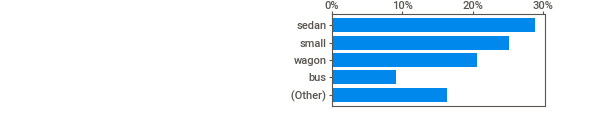
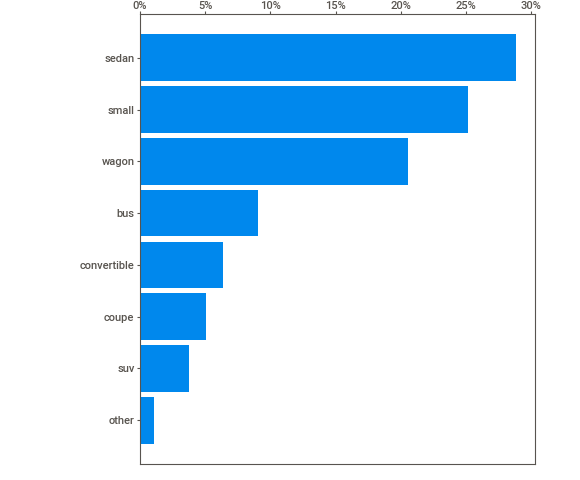
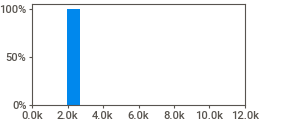
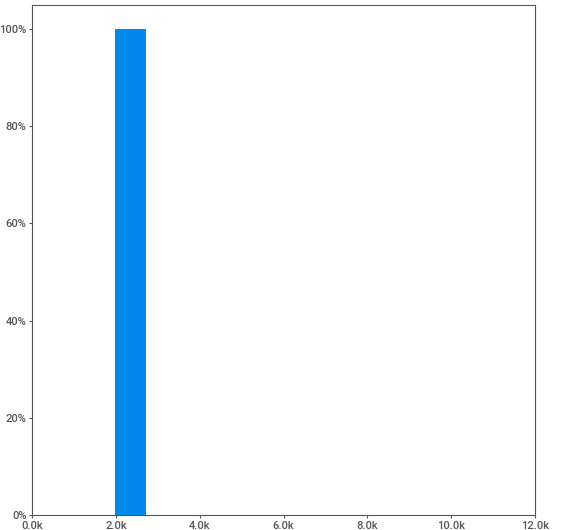
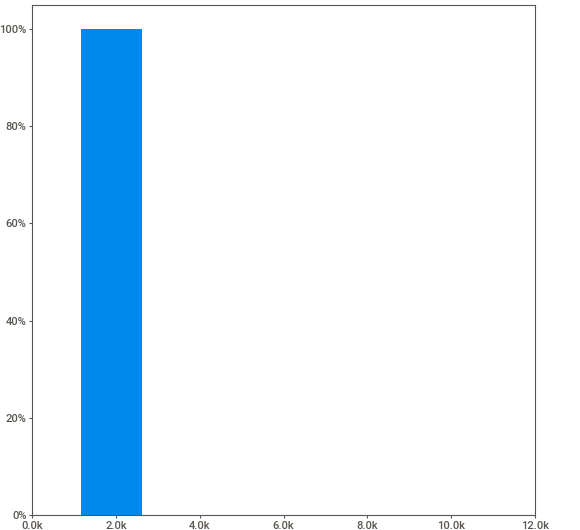
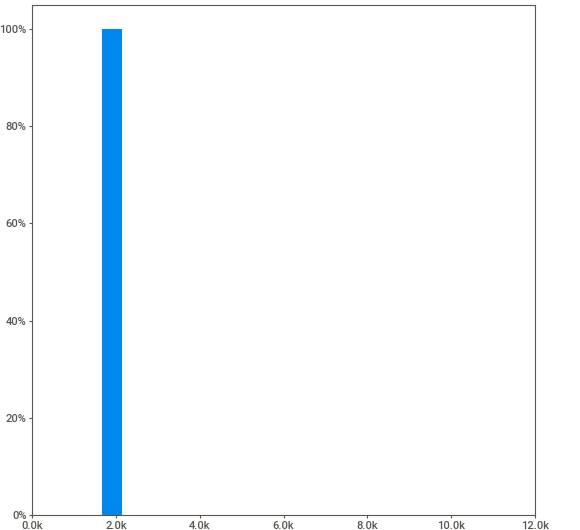
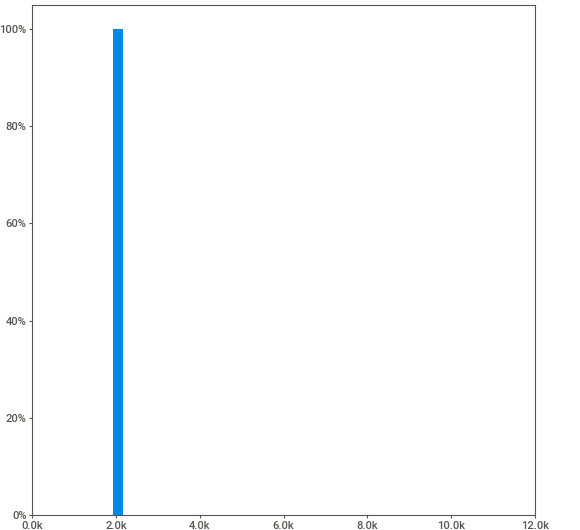
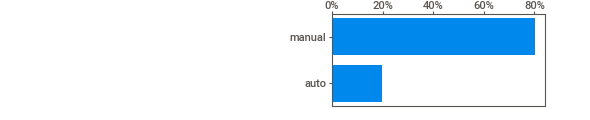
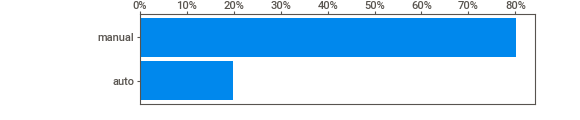
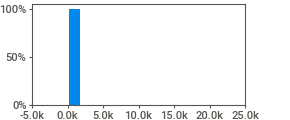
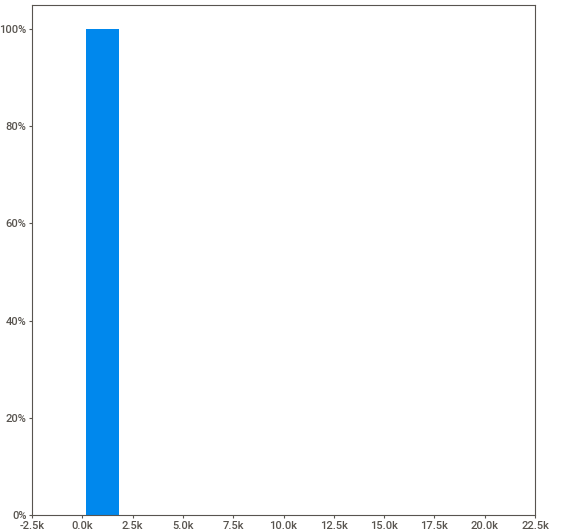
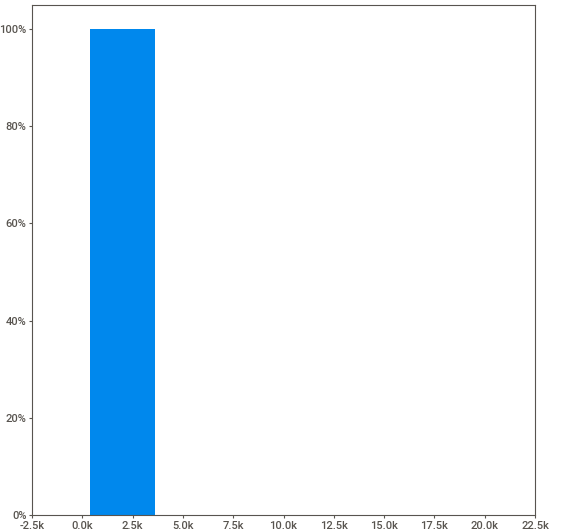
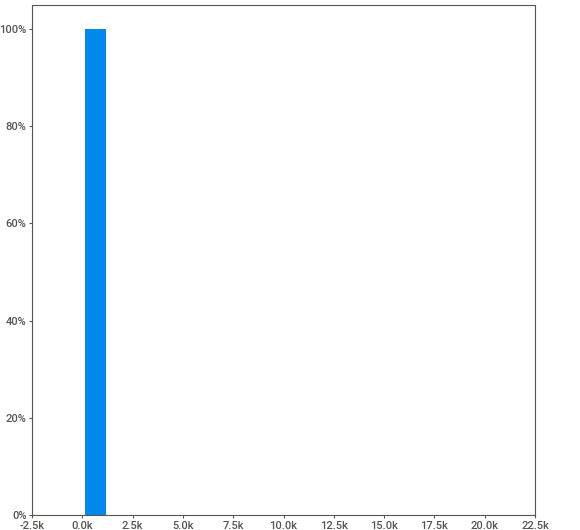
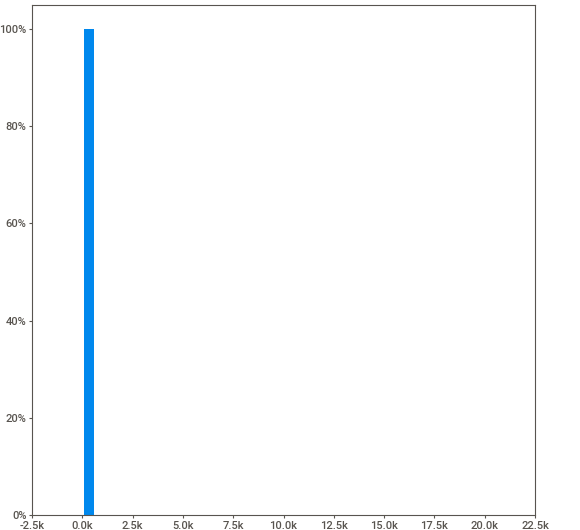
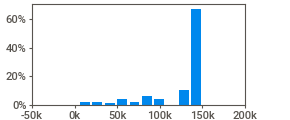
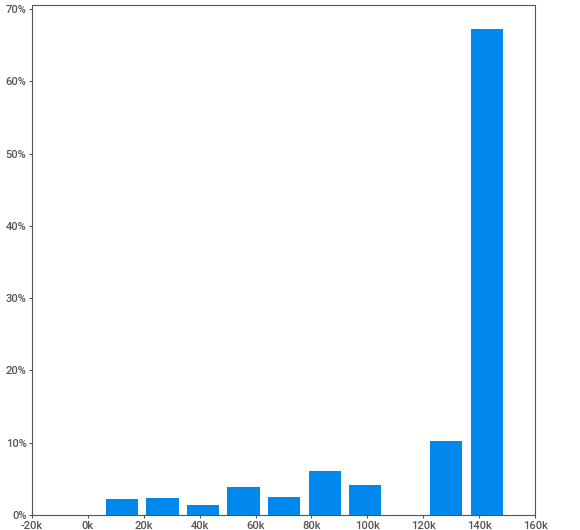
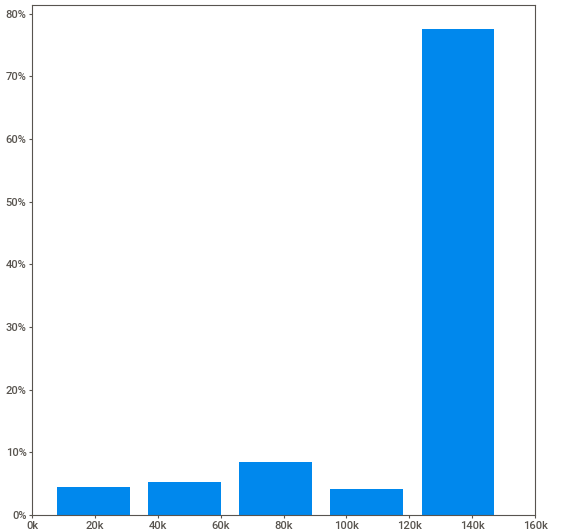
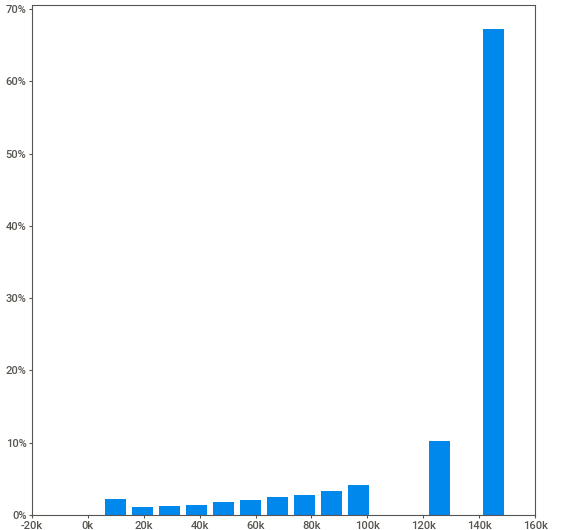
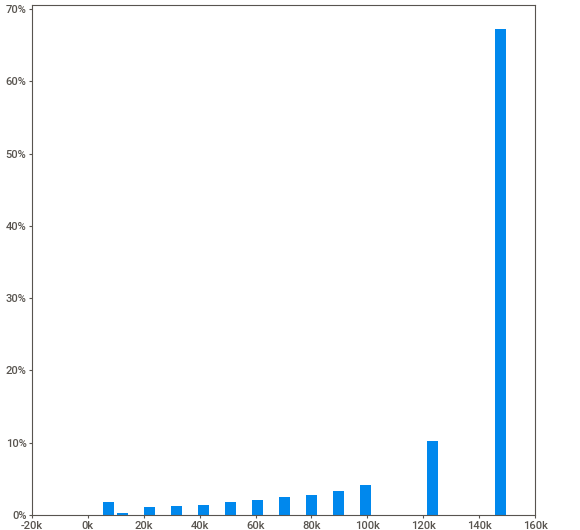
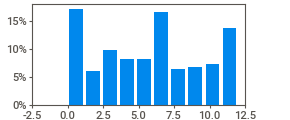
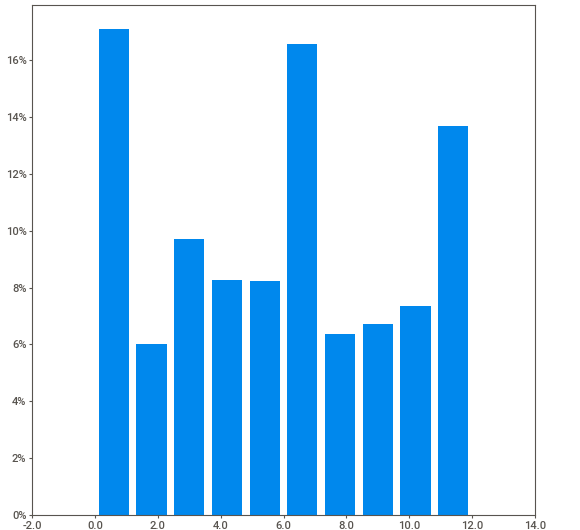
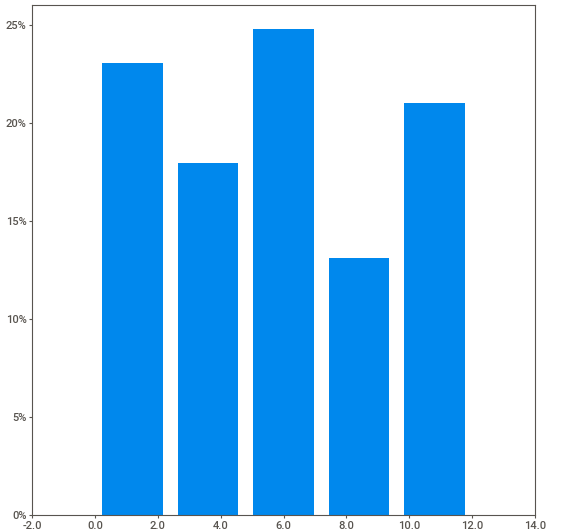
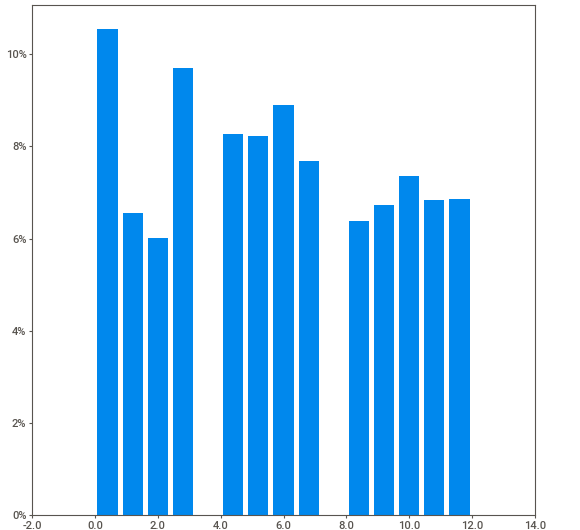
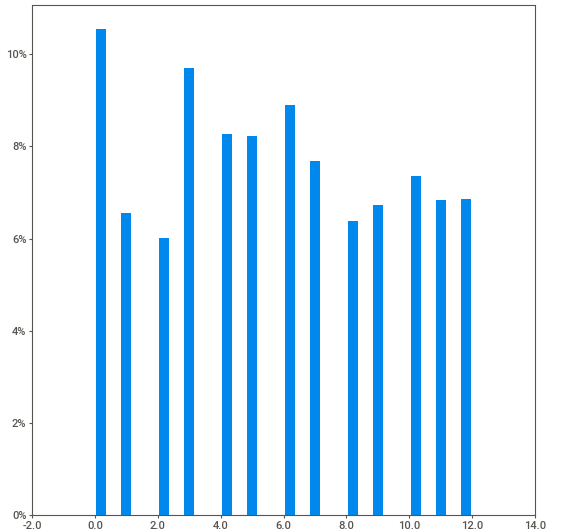
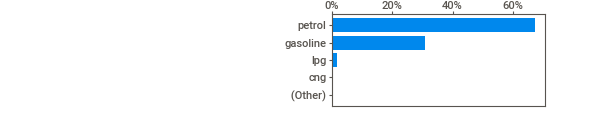
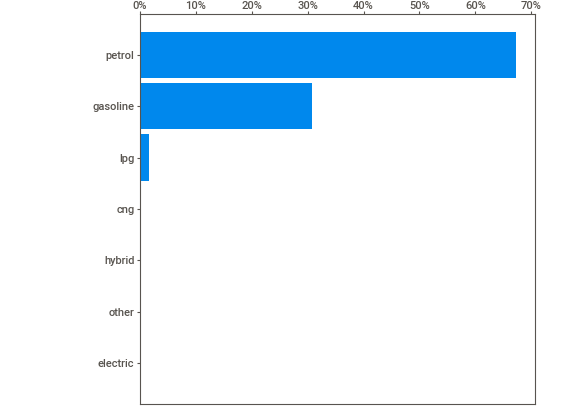
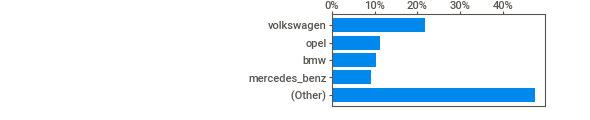
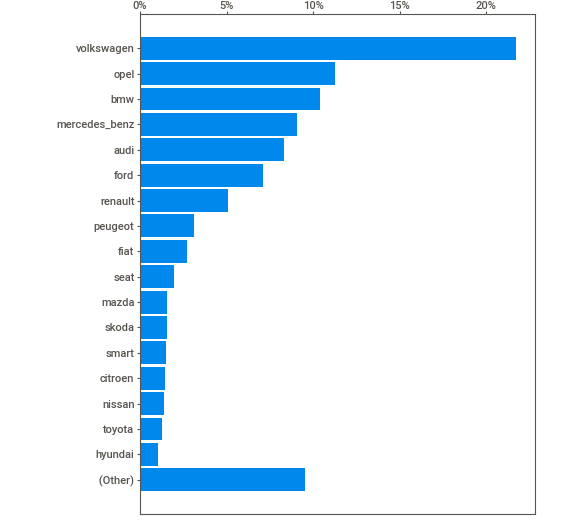
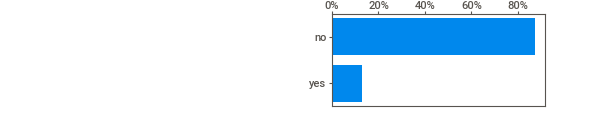
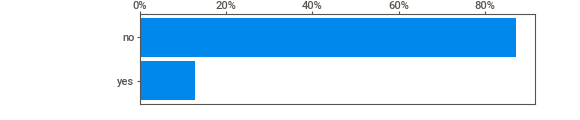
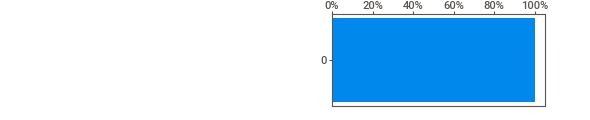
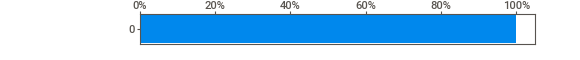
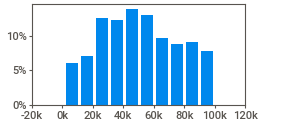
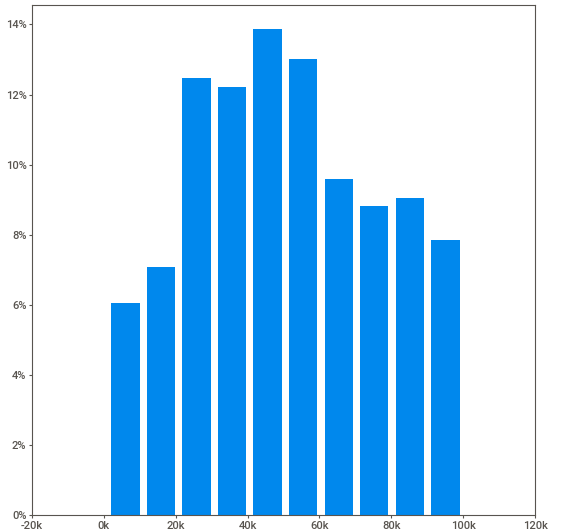
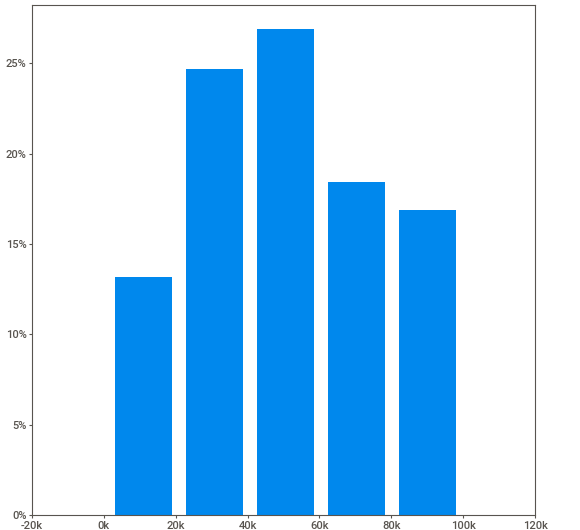
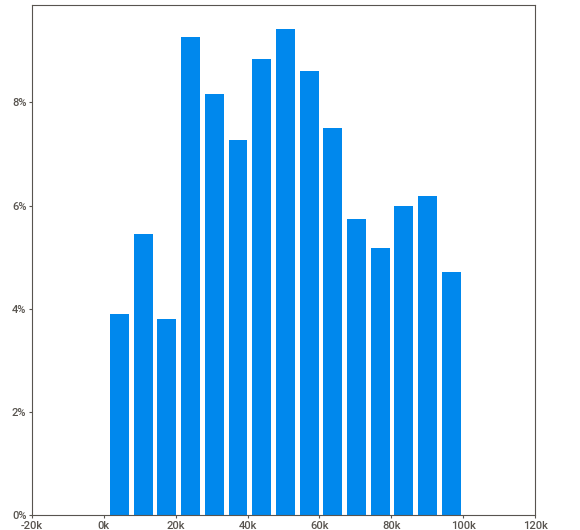
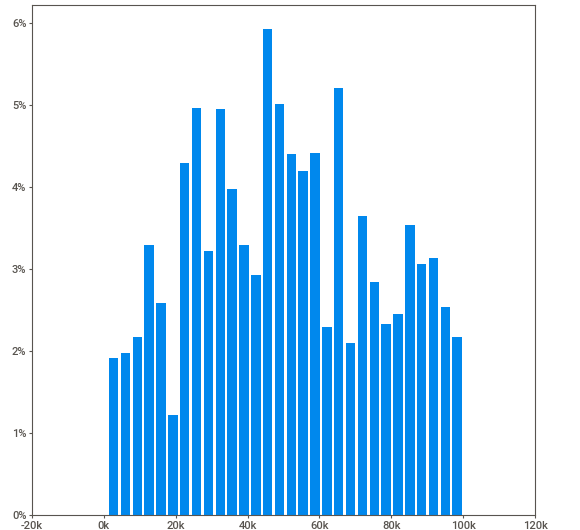
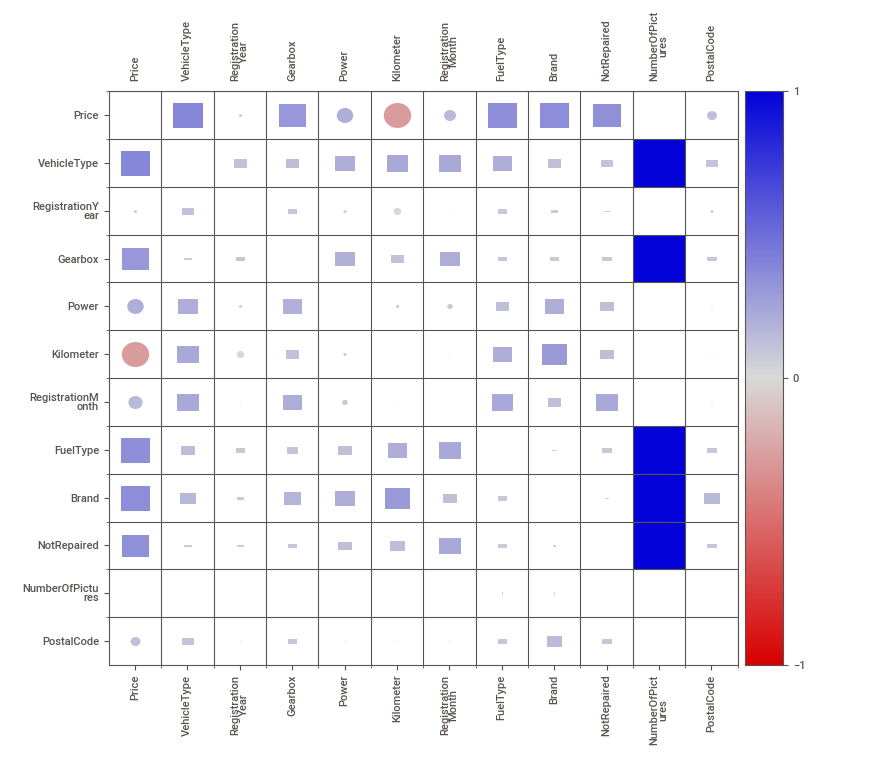
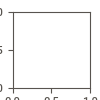

In [10]:
report_0.show_html('common_analysis.html')
report_0.show_notebook(layout='vertical', w=900, h=700, scale=0.8)

<div class="alert alert-info">
    
<font size="3"><b> Из отчета по корелляции видно, что наибольшее влияние оказывают на целевой признак - VehicleType, Gearbox, 
Kilometer, FuelType, Brand, NotRepaired, Power, RegistrationYear. Остальные столбцы удалим, а с оставшимися поработаем с пропусками. Нужно учесть, конечно, что столбец Model придется оставить.

</b></font>
    
</div>

### Удаление столбцов

In [11]:
autos_new = autos[['VehicleType', 
                    'Gearbox', 
                    'Kilometer',
                    'FuelType',
                    'Brand',
                    'NotRepaired',
                    'Model',
                    'Power',
                    'RegistrationYear',
                    'Price']]
autos_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       316875 non-null  object
 1   Gearbox           334532 non-null  object
 2   Kilometer         354365 non-null  int64 
 3   FuelType          321470 non-null  object
 4   Brand             354365 non-null  object
 5   NotRepaired       283211 non-null  object
 6   Model             334660 non-null  object
 7   Power             354365 non-null  int64 
 8   RegistrationYear  354365 non-null  int64 
 9   Price             354365 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


### Обработка выбросов

#### Обработка выбросов по Price

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

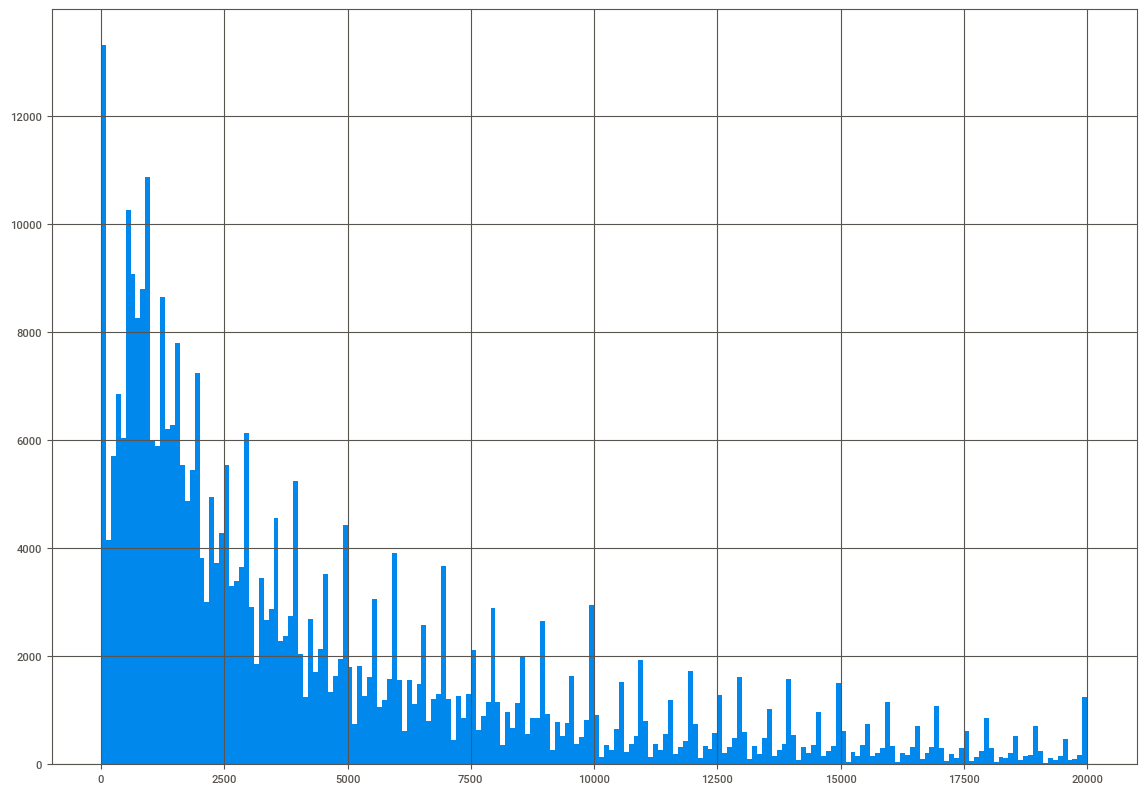

In [12]:
autos_new['Price'].hist(bins=200, figsize=(14,10))
autos_new['Price'].describe()

<div class="alert alert-info">
    
<font size="3"><b> Есть значительное число машин с нулевой ценой, сорее всего эти машины легче отдать даром. чем утилизировать.
Но у нас задача оценить машину по общим критериям, а для оценки первого случая нужно было ввести дополнительный признак. 

</b></font>
    
</div>

In [13]:
autos_new['Price'].quantile(0.05)

200.0

In [14]:
autos_new = autos_new.query('200 <= Price <= 14425')
len(autos_new)

317924

 
<div class="alert alert-info">
    
<font size="3"><b> В данном случае отсекли только экстремальные выбросы c нижней границей в 5 процентов верхней Q3 + 1,5IQR И посмотрели сколько строк осталось для обучения. 

</b></font>
    
</div>

#### Обработка выбросов по VehicleType

In [15]:
autos_new['VehicleType'].unique()

array([nan, 'suv', 'small', 'sedan', 'convertible', 'wagon', 'bus',
       'coupe', 'other'], dtype=object)

<div class="alert alert-info">
    
<font size="3"><b> Здесь только пропуски.

</b></font>
    
</div>

#### Обработка выбросов по Gearbox

In [16]:
autos_new['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

<div class="alert alert-info">
    
<font size="3"><b> Здесь только пропуски.

</b></font>
    
</div>

#### Обработка выбросов по Kilometer

count    317924.000000
mean     130566.346045
std       35453.532213
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

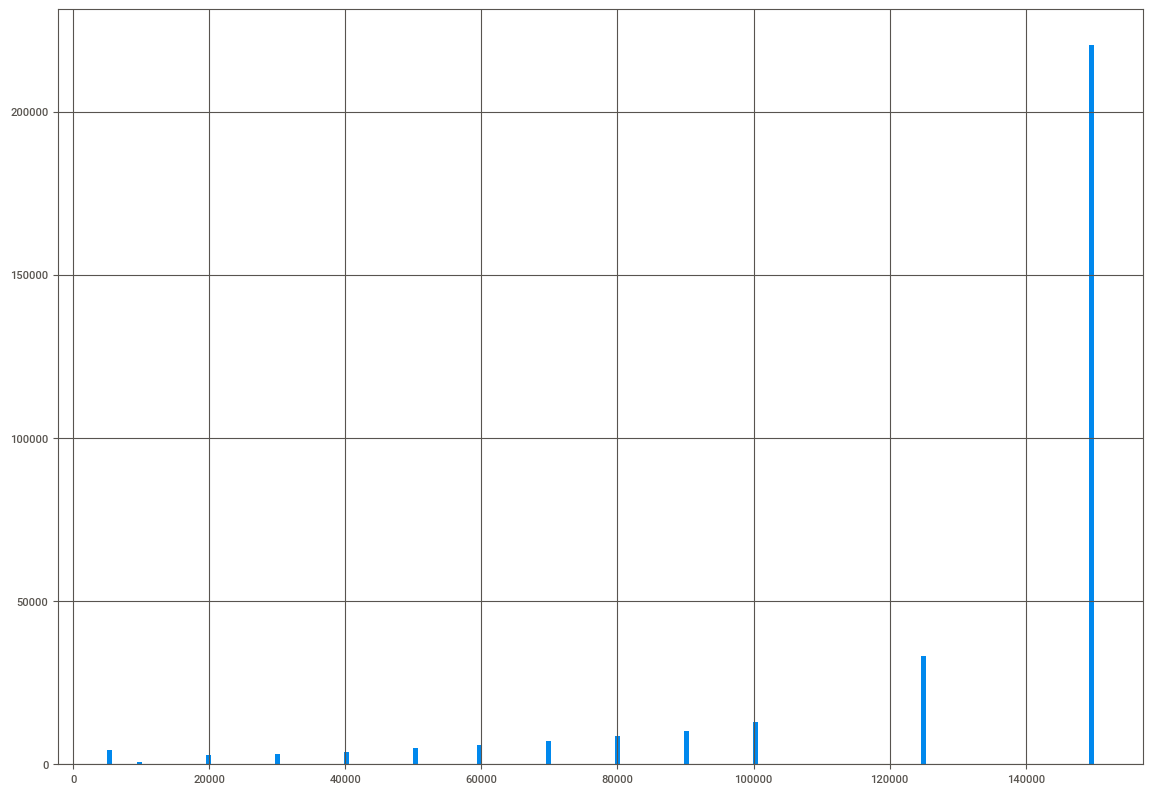

In [17]:
autos_new['Kilometer'].hist(bins=200, figsize=(14,10))
autos_new['Kilometer'].describe()

<div class="alert alert-info">
    
<font size="3"><b> Да, исходя из графика, подавляющее большинство - это машины которым за 140к, но и максимум 150к, а минимум 5к.
Все в пределах.

</b></font>
    
</div>

#### Обработка выбросов по FuelType

In [18]:
autos_new['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

<div class="alert alert-info">
    
<font size="3"><b> Здесь только пропуски.

</b></font>
    
</div>

#### Обработка выбросов по Brand

In [19]:
autos_new['Brand'].unique()

array(['volkswagen', 'jeep', 'skoda', 'bmw', 'peugeot', 'mazda', 'ford',
       'renault', 'mercedes_benz', 'opel', 'seat', 'citroen', 'honda',
       'fiat', 'mini', 'smart', 'hyundai', 'audi', 'nissan', 'alfa_romeo',
       'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia',
       'sonstige_autos', 'toyota', 'chevrolet', 'dacia', 'daihatsu',
       'chrysler', 'jaguar', 'daewoo', 'rover', 'porsche', 'saab',
       'trabant', 'land_rover', 'lada'], dtype=object)

<div class="alert alert-info">
    
<font size="3"><b> Здесь даже пропусков нет.

</b></font>
    
</div>

#### Обработка выбросов по NotRepaired

In [20]:
autos_new['NotRepaired'].unique()

array([nan, 'no', 'yes'], dtype=object)

<div class="alert alert-info">
    
<font size="3"><b> Здесь только пропуски.

</b></font>
    
</div>

#### Обработка выбросов по Power

count    317924.000000
mean        108.121645
std         189.649392
min           0.000000
25%          69.000000
50%         102.000000
75%         140.000000
max       20000.000000
Name: Power, dtype: float64

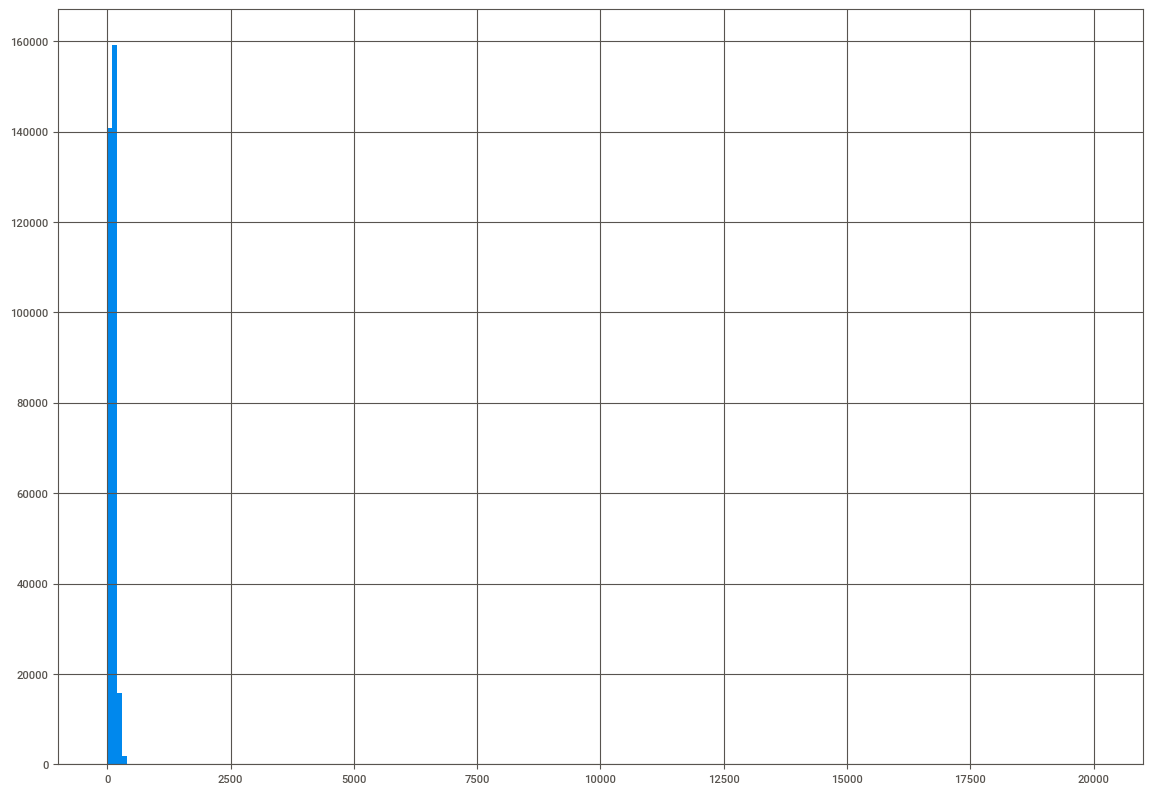

In [21]:
autos_new['Power'].hist(bins=200, figsize=(14,10))
autos_new['Power'].describe()

<div class="alert alert-info">
    
<font size="3"><b> Ничего не видно, сделаем срез вначале по максимальной.
</b></font>
    
</div>

count    317540.000000
mean        104.452211
std          59.173920
min           0.000000
25%          69.000000
50%         102.000000
75%         140.000000
max         476.000000
Name: Power, dtype: float64

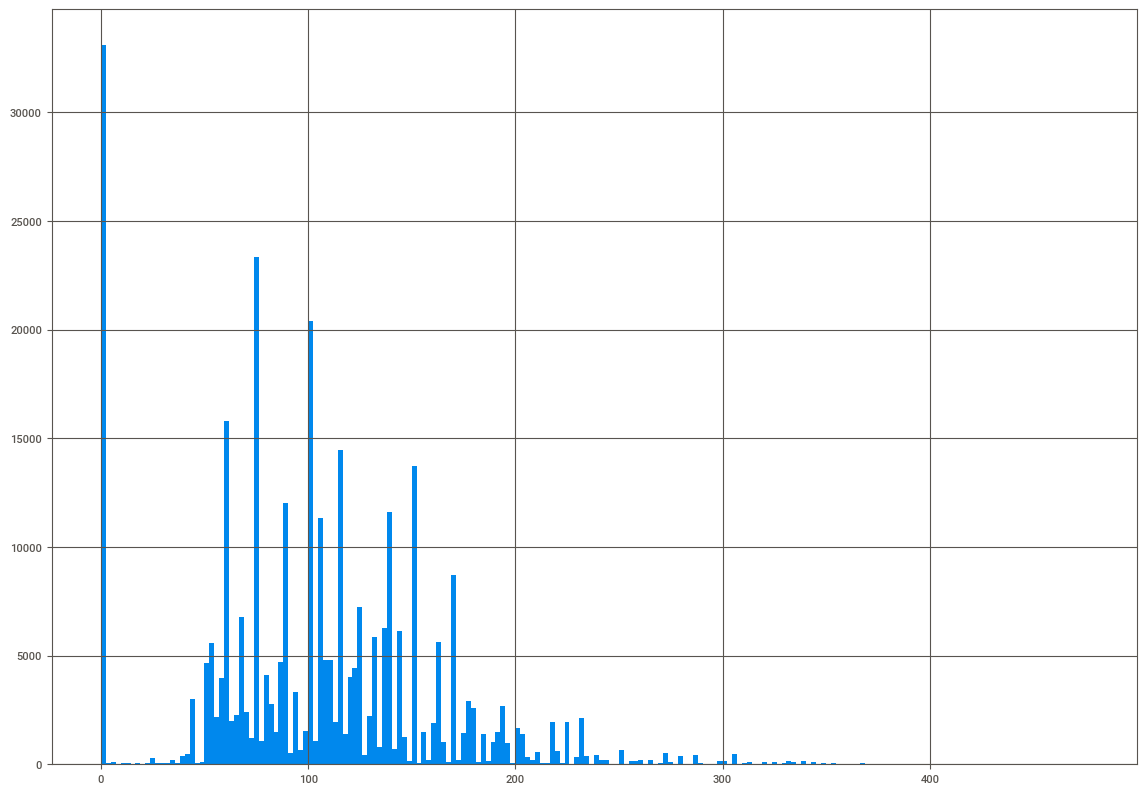

In [22]:
autos_new = autos_new.query('Power < 500')
autos_new['Power'].hist(bins=200, figsize=(14,10))
autos_new['Power'].describe()

<div class="alert alert-info">
    
<font size="3"><b> Большое количество нулей, по всей видимости недочеты в заполнении. Остальные данные распределены
    более-менее по Пуассону. Как ни жалко, придется резать.
</b></font>
    
</div>

In [23]:
autos_new = autos_new.query('Power > 40')
len(autos_new)

282951

### Обработка выбросов по RegistrationYear

count    282951.000000
mean       2003.247958
std          28.573120
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

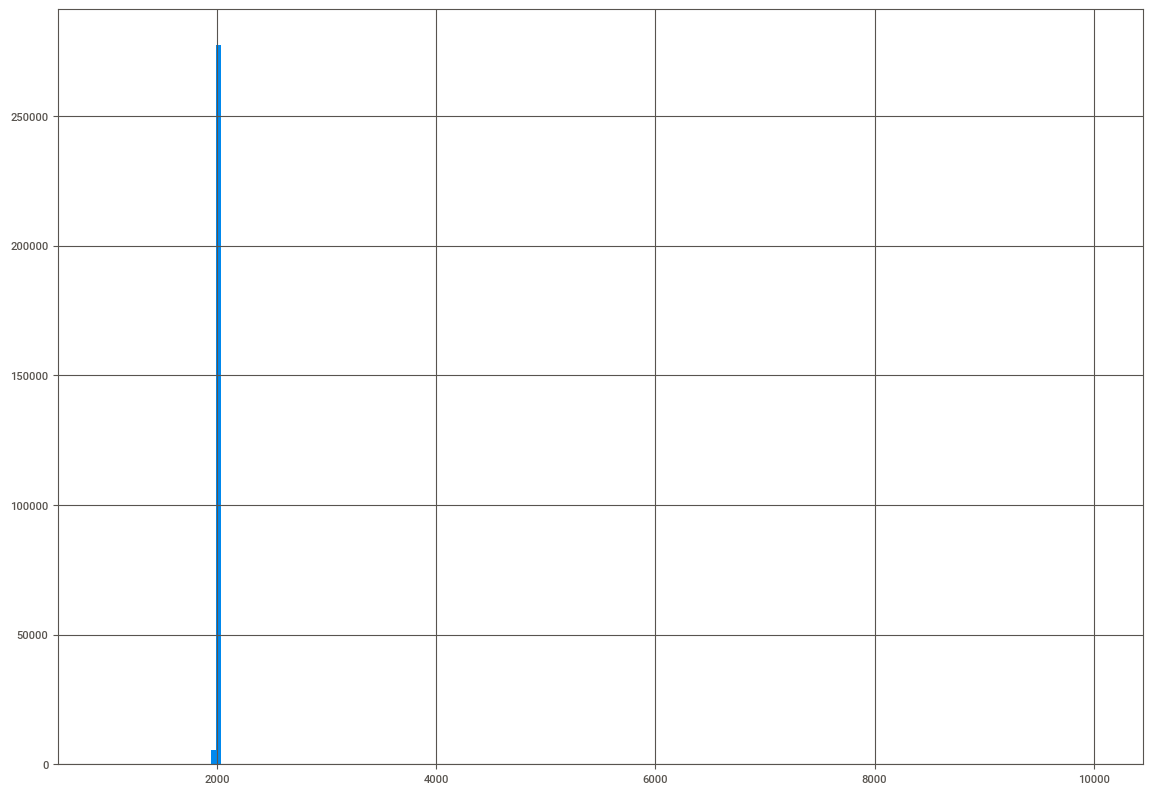

In [24]:
autos_new['RegistrationYear'].hist(bins=200, figsize=(14,10))
autos_new['RegistrationYear'].describe()

<div class="alert alert-info">
    
<font size="3"><b> Придется резать, исходя из здравого смысла.
</b></font>
    
</div>

count    273054.000000
mean       2002.571755
std           6.098034
min        1951.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

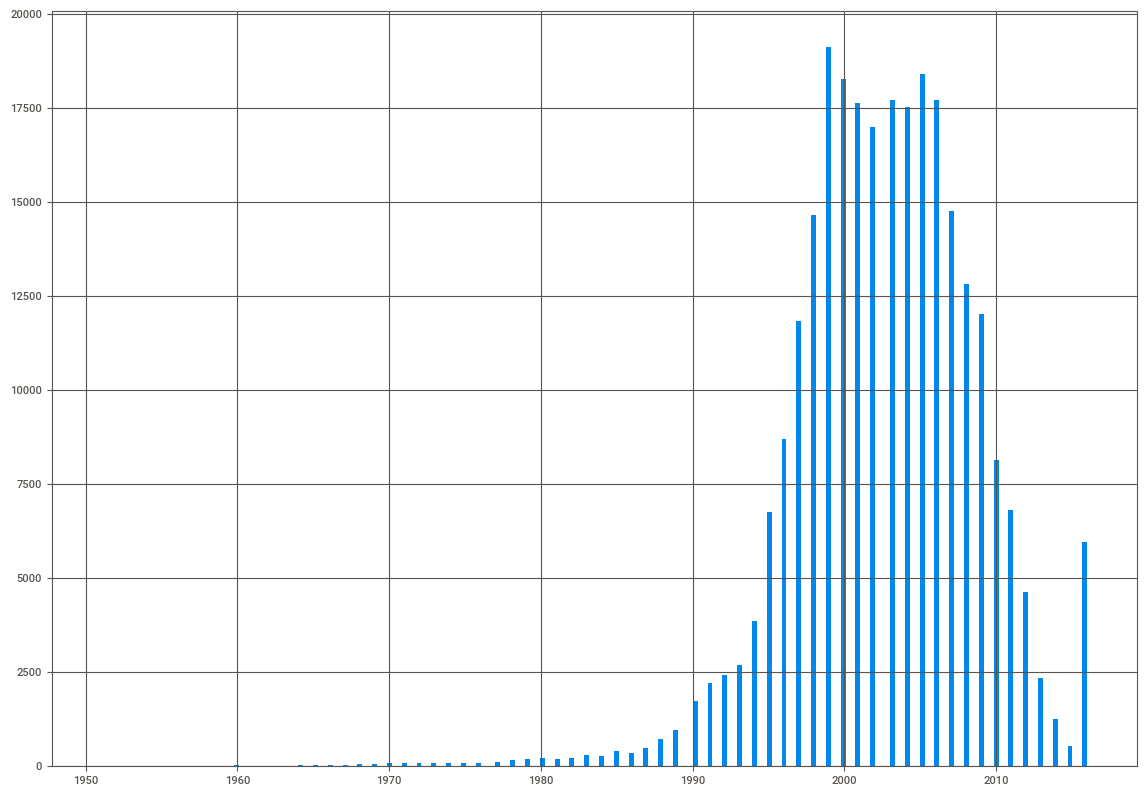

In [25]:
autos_new = autos_new.query('1950 < RegistrationYear < 2017')
autos_new['RegistrationYear'].hist(bins=200, figsize=(14,10))
autos_new['RegistrationYear'].describe()

<div class="alert alert-info">
    
<font size="3"><b> Поставил срез ниже 2017, так как даты объявлений датируются 2016 годом. Внизу у нас граница 1951 год.
</b></font>
    
</div>

### Обработка пропусков

In [26]:
# меняем пропуски в колонке NotRepaired
autos_new['NotRepaired'].fillna('yes', inplace=True)

<div class="alert alert-info">
    
<font size="3"><b> Исходим из предположения, что если машина не была в ремонте, то при ответе была ли она там, отвечающий мог
поставить любую загогулину, которая и не была обработана.

</b></font>
    
</div>

In [27]:
# меняем пропуски в колонке Model
autos_new['Model'].fillna('unknown', inplace=True)

<div class="alert alert-info">
    
<font size="3"><b> Так как для разных брендов разные модели могут иметь разную стоимость заменим на 'unknown'.

</b></font>
    
</div>

In [28]:
# меняем пропуски в колонке VehicleType
autos_new['VehicleType'].fillna('unknown', inplace=True)

# меняем пропуски в колонке Gearbox
autos_new['Gearbox'].fillna('unknown', inplace=True)

# меняем пропуски в колонке Fueltype
autos_new['FuelType'].fillna('unknown', inplace=True)

<div class="alert alert-info">
    
<font size="3"><b> Аналогично заменил в остальных столбцах на 'unknown'.

</b></font>
    
</div>

### Кодирование категориальных признаков с помощью LabelEncoder

In [29]:
autos_new.loc[:, 'VehicleType'] = LabelEncoder().fit_transform(autos_new.loc[:, 'VehicleType'])
autos_new.loc[:, 'Gearbox'] = LabelEncoder().fit_transform(autos_new.loc[:, 'Gearbox'])
autos_new.loc[:, 'Model'] = LabelEncoder().fit_transform(autos_new.loc[:, 'Model'])
autos_new.loc[:, 'FuelType'] = LabelEncoder().fit_transform(autos_new.loc[:, 'FuelType'])
autos_new.loc[:, 'Brand'] = LabelEncoder().fit_transform(autos_new.loc[:, 'Brand'])
autos_new.loc[:, 'NotRepaired'] = LabelEncoder().fit_transform(autos_new.loc[:, 'NotRepaired'])

<div class="alert alert-info">
    
<font size="3"><b> Закодировал.

</b></font>
    
</div>

### Проверка корелляции

In [30]:
print(autos_new.corr()['Price'].sort_values())

Kilometer          -0.335136
FuelType           -0.295170
NotRepaired        -0.251700
Gearbox            -0.211781
Brand              -0.093357
VehicleType        -0.083641
Model              -0.045248
Power               0.459151
RegistrationYear    0.493933
Price               1.000000
Name: Price, dtype: float64


<div class="alert alert-info">
    
<font size="3"><b> Видно, что корелляция между целевым признаком и признаками ниже 0,8. Можно строить модель.

</b></font>
    
</div>

## Обучение моделей

### Признаки и таргеты

In [31]:
X = autos_new.drop('Price',axis=1)
Y = autos_new['Price']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 12345)

<div class="alert alert-info">
    
<font size="3"><b> Определил признаки.

</b></font>
    
</div>

### Масштабируем признаки

In [32]:
scaler = StandardScaler()
scaler.fit(x_train) 

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test) 

### Функция обучения и подсчета времени

In [33]:
def fit_time(model, x_train_scaled, y_train):
    
    start = time.time()
    model.fit(x_train_scaled, y_train)
    end = time.time()
    time_fit = end - start
    return model, time_fit

<div class="alert alert-info">
    
<font size="3"><b> Задал функцию обучения и подсчета времени.

</b></font>
    
</div>

### Функция предсказания и подсчета времени

In [34]:
def predict_time(model, x_test_scaled):
    
    start = time.time()
    predict = model.predict(x_test_scaled)
    end = time.time()
    time_predict = end - start
    return predict, time_predict

In [35]:
# cформируем датафрейм для результатов
result = pd.DataFrame(columns=['RMSE','Learning_time','Predict_time'])

<div class="alert alert-info">
    
<font size="3"><b> Задал функцию предсказания и подсчета времени.

</b></font>
    
</div>

### Функция добавления результатов

In [36]:
def autos_metrics(model, RMSE, f_time, pred_time, df):
    
    df.loc[model,'Model'] = model
    df.loc[model,'RMSE'] = RMSE
    df.loc[model,'Learning_time'] = f_time
    df.loc[model,'Predict_time'] = pred_time
    
    return df

<div class="alert alert-info">
    
<font size="3"><b> Задал функцию добавления результатов в общую таблицу.

</b></font>
    
</div>

### Линейная регрессия

In [37]:
LR_model, LR_learn_time = fit_time(LinearRegression(), x_train_scaled, y_train)
LR_predict, LR_pred_time = predict_time(LR_model, x_test_scaled)
LR_RMSE = np.sqrt(mean_squared_error(y_test, LR_predict))
autos_metrics('Linear regression', LR_RMSE, LR_learn_time, LR_pred_time, result)

,RMSE,Learning_time,Predict_time,Model
Linear regression,2321.339401,0.044952,0.011894,Linear regression


<div class="alert alert-info">
    
<font size="3"><b> Посчитал метрику и время для линейной регресии.

</b></font>
    
</div>

### Дерево решений

In [38]:
D_tree, D_tree_learn_time = fit_time(DecisionTreeRegressor(), x_train_scaled, y_train)
D_tree_predict, D_tree_pred_time = predict_time(D_tree, x_test_scaled)
D_tree_RMSE = np.sqrt(mean_squared_error(y_test, D_tree_predict))
autos_metrics('Decision Tree', D_tree_RMSE, D_tree_learn_time, D_tree_pred_time, result)

,RMSE,Learning_time,Predict_time,Model
Linear regression,2321.339401,0.044952,0.011894,Linear regression
Decision Tree,1577.812095,0.830332,0.032135,Decision Tree


<div class="alert alert-info">
    
<font size="3"><b> Посчитал метрику и время для дерева решений.

</b></font>
    
</div>

### Случайный лес

In [39]:
RF_model, RF_learn_time = fit_time(RandomForestRegressor(n_estimators=25,random_state=12345), x_train_scaled, y_train)
RF_predict, RF_pred_time = predict_time(RF_model, x_test_scaled)
RF_RMSE = np.sqrt(mean_squared_error(y_test, RF_predict))
autos_metrics('Random Forest', RF_RMSE, RF_learn_time, RF_pred_time, result)

,RMSE,Learning_time,Predict_time,Model
Linear regression,2321.339401,0.044952,0.011894,Linear regression
Decision Tree,1577.812095,0.830332,0.032135,Decision Tree
Random Forest,1333.700799,12.94993,0.705654,Random Forest


<div class="alert alert-info">
    
<font size="3"><b> Посчитал метрику и время для случайного леса.

</b></font>
    
</div>

### Регрессия LGBMRegressor

In [40]:
LGB_model, LGB_learn_time = fit_time(LGBMRegressor(num_leaves=31, 
                                                   learning_rate=0.05, random_state=12345), x_train_scaled, y_train) 
LGB_predict, LGB_pred_time = predict_time(LGB_model, x_test_scaled)
LGB_RMSE = np.sqrt(mean_squared_error(y_test, LGB_predict))
autos_metrics('Lightgbm', LGB_RMSE, LGB_learn_time, LGB_pred_time, result)

,RMSE,Learning_time,Predict_time,Model
Linear regression,2321.339401,0.044952,0.011894,Linear regression
Decision Tree,1577.812095,0.830332,0.032135,Decision Tree
Random Forest,1333.700799,12.94993,0.705654,Random Forest
Lightgbm,1462.293904,385.55953,0.59849,Lightgbm


<div class="alert alert-info">
    
<font size="3"><b> Посчитал метрику и время для регрессии LGBMR.

</b></font>
    
</div>

### GradientBoostingRegressor

In [41]:
GBR_model, GBR_learn_time = fit_time(GradientBoostingRegressor(n_estimators=50,random_state=12345), x_train_scaled, y_train)
GBR_predict, GBR_pred_time = predict_time(GBR_model, x_test_scaled)
GBR_RMSE = np.sqrt(mean_squared_error(y_test, GBR_predict))
autos_metrics('GradientBoostingRegressor', GBR_RMSE, GBR_learn_time, GBR_pred_time, result)

,RMSE,Learning_time,Predict_time,Model
Linear regression,2321.339401,0.044952,0.011894,Linear regression
Decision Tree,1577.812095,0.830332,0.032135,Decision Tree
Random Forest,1333.700799,12.94993,0.705654,Random Forest
Lightgbm,1462.293904,385.55953,0.59849,Lightgbm
GradientBoostingRegressor,1668.117587,8.395807,0.064373,GradientBoostingRegressor


<div class="alert alert-info">
    
<font size="3"><b> Посчитал метрику и время для регрессии GradientBoostingRegressor.

</b></font>
    
</div>

### Случайная модель

In [42]:
Y_rand = Y.copy()
Y_rand.loc[:] = Y.mean()

RAND_RMSE = np.sqrt(mean_squared_error(Y, Y_rand))
autos_metrics('Random', RAND_RMSE, 0, 0, result)

,RMSE,Learning_time,Predict_time,Model
Linear regression,2321.339401,0.044952,0.011894,Linear regression
Decision Tree,1577.812095,0.830332,0.032135,Decision Tree
Random Forest,1333.700799,12.94993,0.705654,Random Forest
Lightgbm,1462.293904,385.55953,0.59849,Lightgbm
GradientBoostingRegressor,1668.117587,8.395807,0.064373,GradientBoostingRegressor
Random,3519.482233,0,0,Random


<div class="alert alert-info">
    
<font size="3"><b> Проверил модели на адекватность.

</b></font>
    
</div>

## Анализ моделей

<div class="alert alert-info">
    
<font size="3"><b> Наилучшие результаты показала модель случайного леса по RMSE, наихудший - линейная регрессия. По времени
обучения лучший результат у линейной регрессии, наихудший Lightgbm. Можно сделать вывод, что лучше всего отработала модель случайного леса.

</b></font>
    
</div>

Верно,принимаем